In [11]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.function as fn
import dgl.nn as gnn
from tqdm import tqdm

import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings("ignore")
import faiss
from training_utils import *
from torch.utils.tensorboard import SummaryWriter
from random import shuffle
import faiss

# Preprocessing

In [84]:
g = joblib.load(filename='../data/graph/okved_graph_new_v3.pickle')
nfeat = g.ndata['feat'].float()
in_feats = nfeat.shape[1]
n_edges = g.num_edges()
# clf_graph = g
g = dgl.edge_subgraph(graph=g, edges=(torch.logical_or(g.edata['type'] == 1, g.edata['type'] == 4)).nonzero().flatten())
okved_data = pd.read_csv('../data/okved2/okved_2014_w_sections.csv', index_col=0)
sections = okved_data['section_id'].values
num_negs = 1
neg_share = False
device = th.device('cpu')
num_hidden = 256
dropout = 0.25
lr = 0.01
num_epochs = 1000
last_improvement = 0
require_improvements = 50

In [15]:
g.edata['weight'].unique(return_counts=True)

(tensor([    1,     4,     5,  ..., 22361, 22866, 23506]),
 tensor([ 5272, 59206, 43268,  ...,     1,     1,     1]))

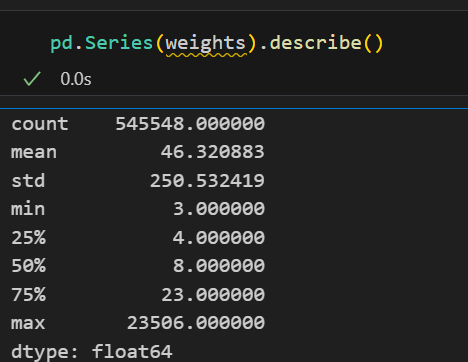

# Graph Attention Network

In [16]:
class GAT(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.GATConv(in_feats, n_hidden, num_heads=4))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.GATConv(n_hidden, n_hidden, num_heads=4))
            self.layers.append(gnn.GATConv(n_hidden, n_classes, num_heads=4))
        else:
            self.layers.append(gnn.GATConv(in_feats, n_classes, num_heads=4))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [17]:
num_layers = 3
best_state = None
writer_path = './runs/gat_v2'
model_name = 'GAT_v2'
model = GAT(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [18]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 148
Best loss = 0.6929957270622253
Best loss = 0.6929957270622253


  File "c:\Users\egrli\envs\okved_embeddings\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\egrli\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\egrli\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\egrli\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


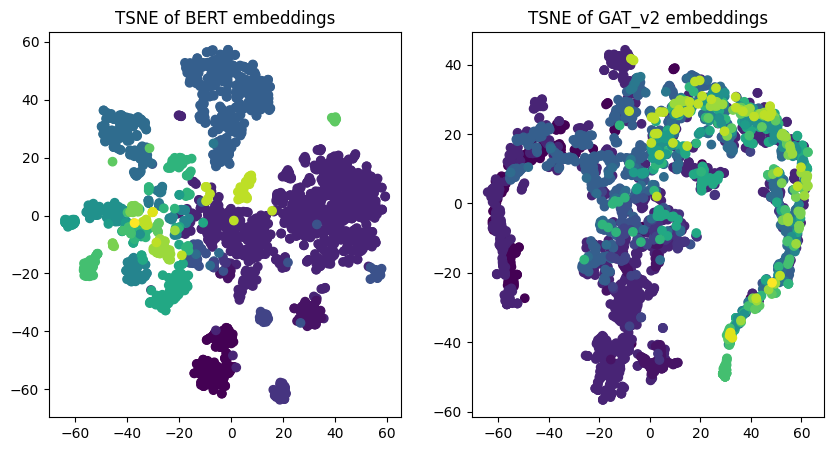

In [19]:
model.eval()
embeddings_model = model(g, nfeat).detach().mean(dim=[1, 2, 3]).numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [20]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=bert_scores, filename=f"../results/scores/scores_bert_v2.pickle")
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -12.70±39.98
Берт: 0.26±0.38
SVR BERT: -0.08
SVR модель: -2.72
Линейная регрессия BERT: 0.09
Линейная регрессия модель -0.06


In [21]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [22]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:02<00:00, 912.19it/s] 


In [23]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

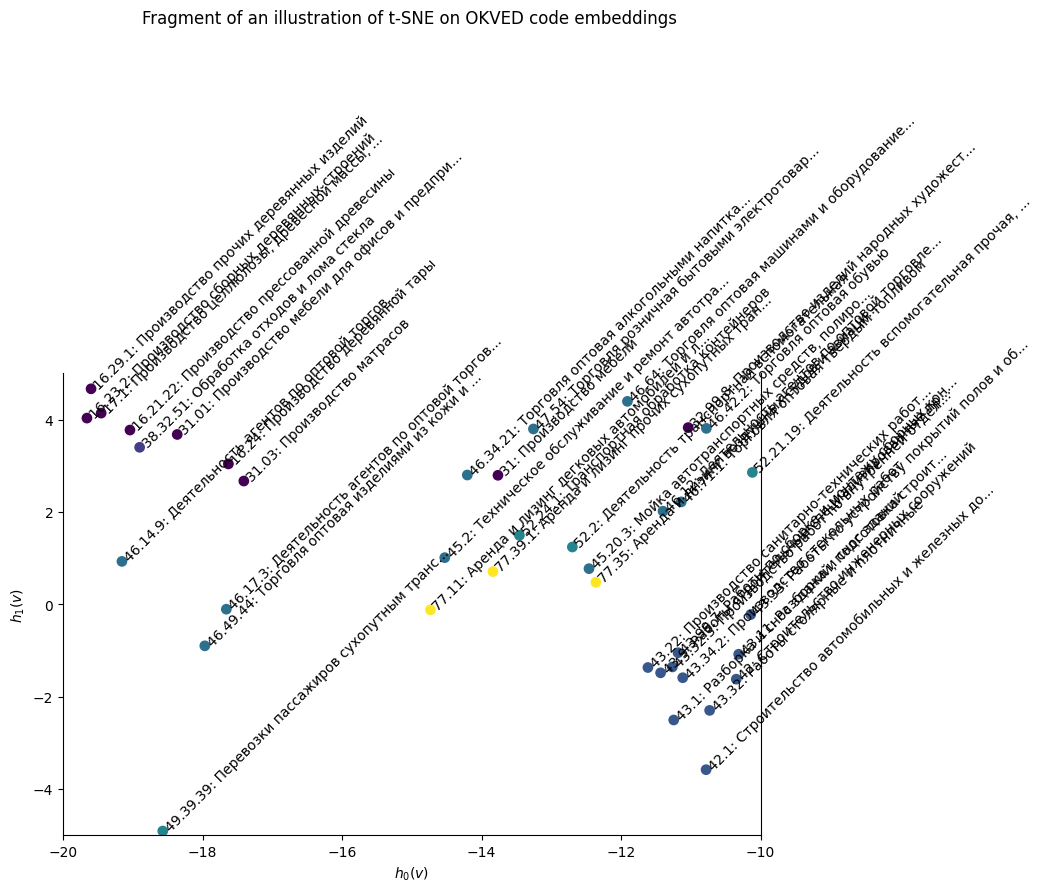

In [24]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# Chebyshev Conv

In [25]:
class ChConv(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.ChebConv(in_feats, n_hidden, k=2))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.ChebConv(n_hidden, n_hidden, k=2))
            self.layers.append(gnn.ChebConv(n_hidden, n_classes, k=2))
        else:
            self.layers.append(gnn.ChebConv(in_feats, n_classes, k=2))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [85]:
best_state = None
num_layers = 3
writer_path = './runs/cheb_v2'
model_name = 'Cheb_v2'
model = ChConv(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [86]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 56
Best loss = 0.6929067373275757
Best loss = 0.6929067373275757


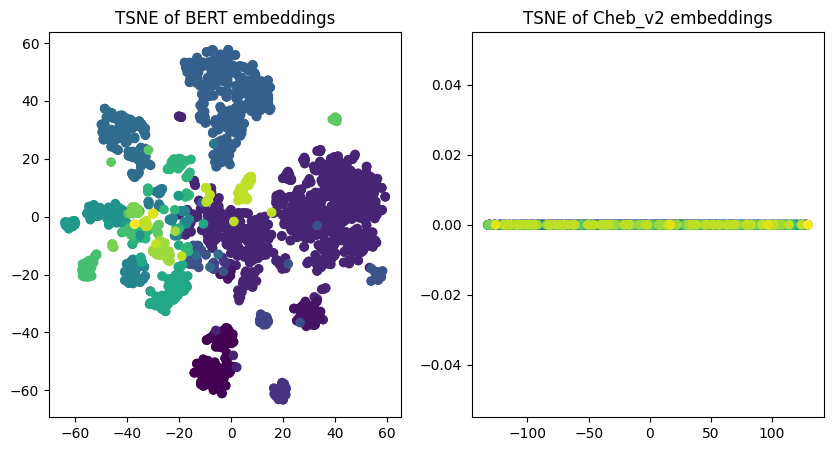

In [87]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [88]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: 0.02±0.01
Берт: 0.18±0.38
SVR BERT: -0.08
SVR модель: -2.77
Линейная регрессия BERT: 0.09
Линейная регрессия модель -0.01


In [89]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [90]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:03<00:00, 874.37it/s] 


In [91]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

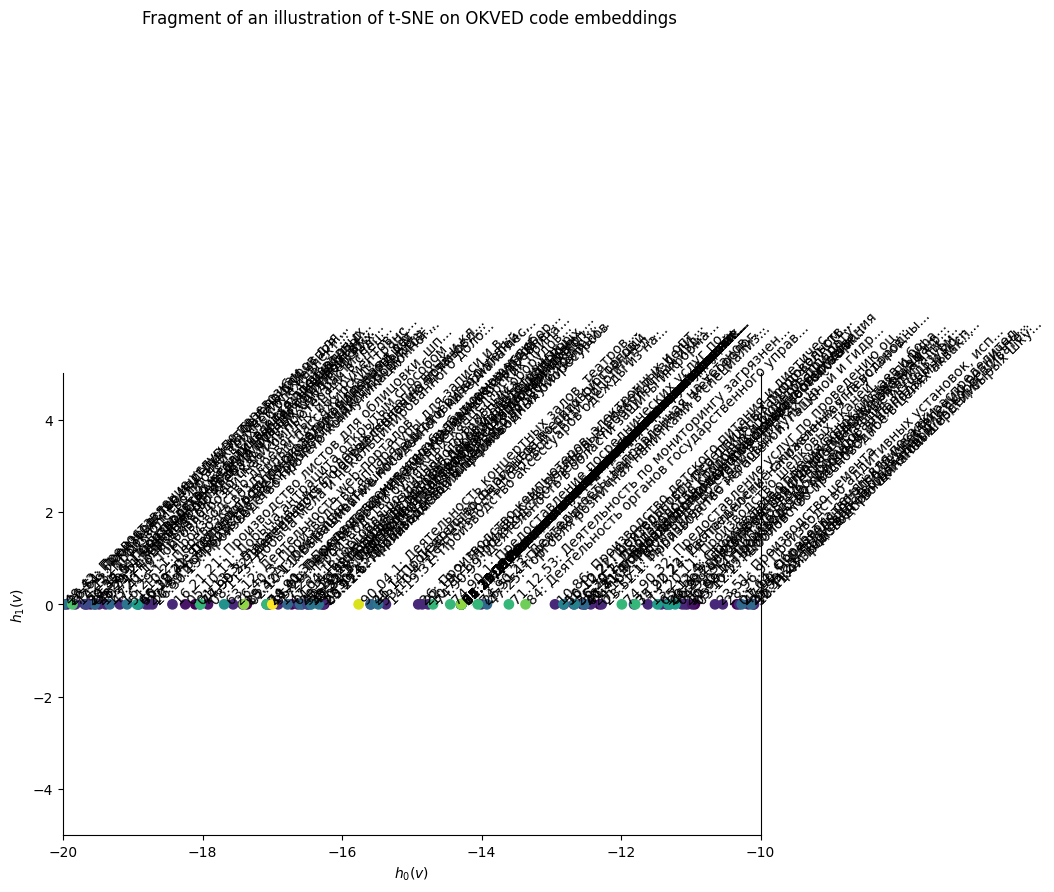

In [92]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# SAGE

In [37]:
class Sage(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.SAGEConv(in_feats, n_hidden, aggregator_type='mean'))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.SAGEConv(n_hidden, n_hidden, aggregator_type='mean'))
            self.layers.append(gnn.SAGEConv(n_hidden, n_classes, aggregator_type='mean'))
        else:
            self.layers.append(gnn.SAGEConv(in_feats, n_classes, aggregator_type='mean'))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [38]:
best_state = None
num_layers = 4
writer_path = './runs/sage_v2'
model_name = 'Sage_v2'
model = Sage(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [39]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 174
Best loss = 0.6930573582649231
Best loss = 0.6930573582649231


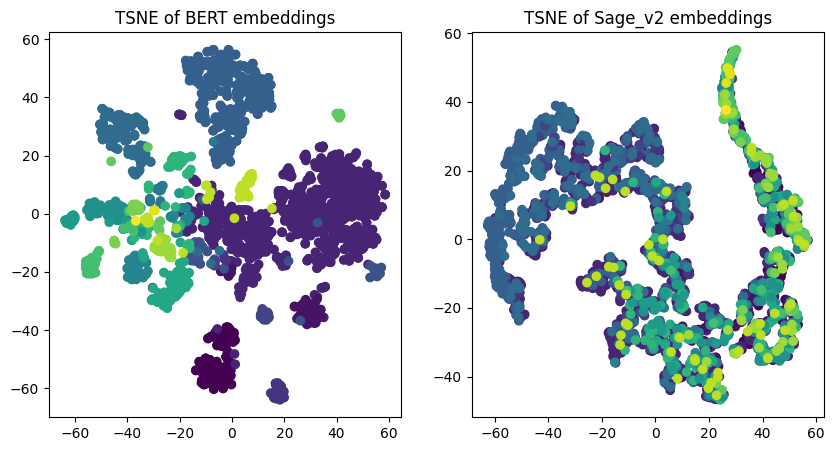

In [40]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [41]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -4.32±20.98
Берт: 0.17±0.52
SVR BERT: -0.08
SVR модель: -2.58
Линейная регрессия BERT: 0.09
Линейная регрессия модель 0.05


In [42]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [43]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:01<00:00, 1353.33it/s]


In [44]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

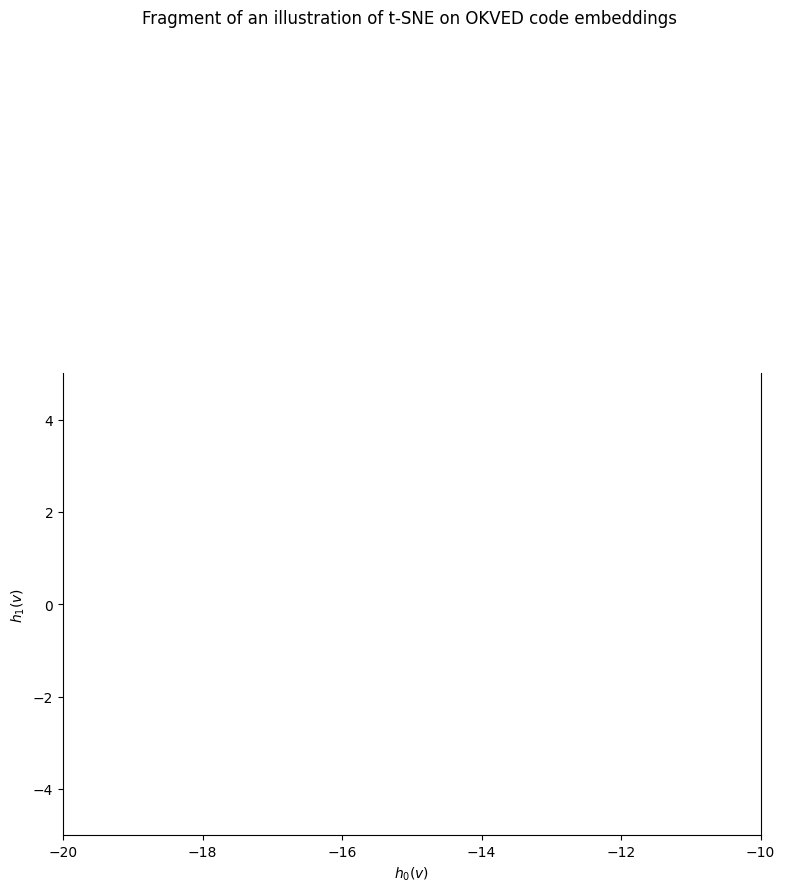

In [45]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# DotGatConv

In [46]:
class DotGat(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.DotGatConv(in_feats, n_hidden, num_heads=4))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.DotGatConv(n_hidden, n_hidden, num_heads=4))
            self.layers.append(gnn.DotGatConv(n_hidden, n_classes, num_heads=4))
        else:
            self.layers.append(gnn.DotGatConv(in_feats, n_classes, num_heads=4))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [47]:
best_state = None
num_layers = 1
writer_path = './runs/dotgat_v2'
model_name = 'DotGat_v2'
model = DotGat(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [48]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

Best loss = 0.6615692377090454


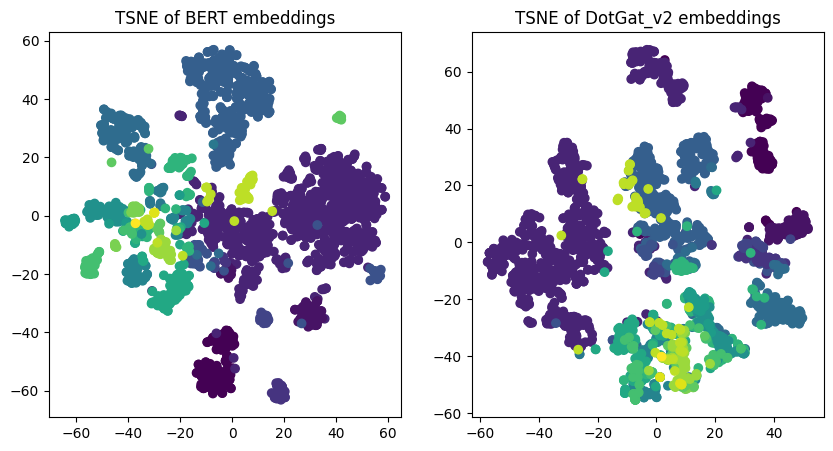

In [49]:
model.eval()
embeddings_model = model(g, nfeat).detach().mean(dim=1).numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [50]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=bert_scores, filename=f"../results/scores/scores_bert.pickle")
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -1.13±0.71
Берт: 0.17±0.40
SVR BERT: -0.08
SVR модель: -0.93
Линейная регрессия BERT: 0.09
Линейная регрессия модель -0.31


In [51]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [52]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:01<00:00, 1695.22it/s]


In [53]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

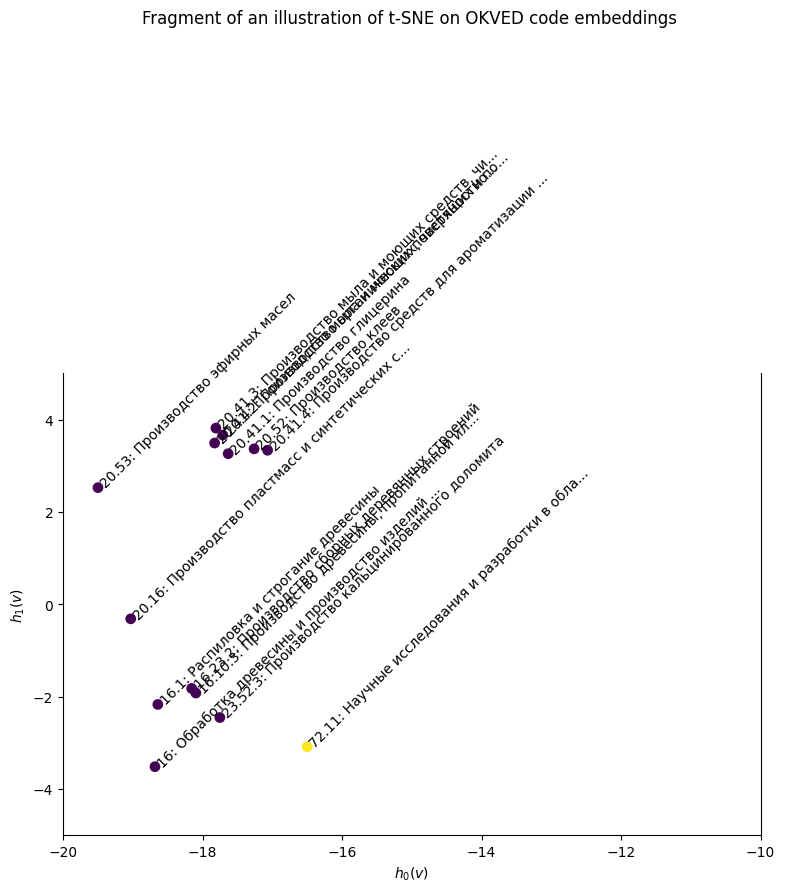

In [54]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# PNAConv

In [55]:
class PNAConv(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.PNAConv(in_feats, n_hidden, ['mean', 'max', 'sum'], ['identity', 'amplification'], 2.5))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.PNAConv(n_hidden, n_hidden, ['mean', 'max', 'sum'], ['identity', 'amplification'], 2.5))
            self.layers.append(gnn.PNAConv(n_hidden, n_classes, ['mean', 'max', 'sum'], ['identity', 'amplification'], 2.5))
        else:
            self.layers.append(gnn.PNAConv(in_feats, n_classes, ['mean', 'max', 'sum'], ['identity', 'amplification'], 2.5))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [56]:
best_state = None
num_layers = 2
writer_path = './runs/PNAConv_v2'
model_name = 'PNAConv_v2'
model = PNAConv(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [57]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

KeyboardInterrupt: 

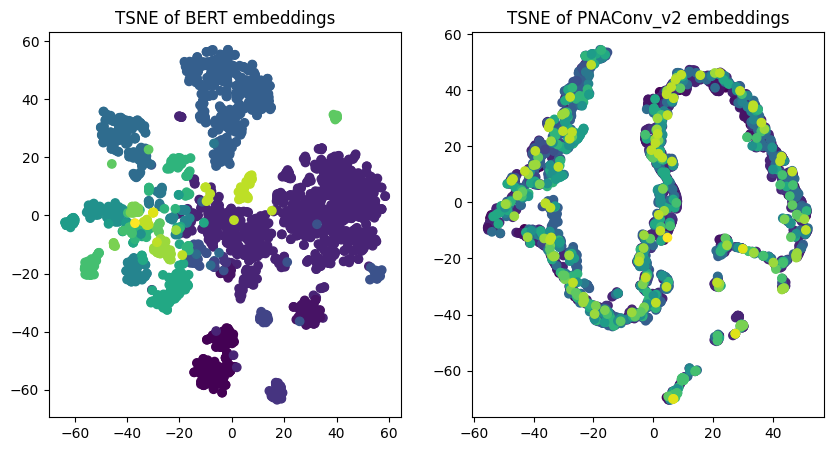

In [58]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [59]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -1.47±1.28
Берт: 0.14±0.49
SVR BERT: -0.08
SVR модель: -2.66
Линейная регрессия BERT: 0.09
Линейная регрессия модель 0.11


In [60]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [61]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:02<00:00, 885.96it/s]


In [62]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

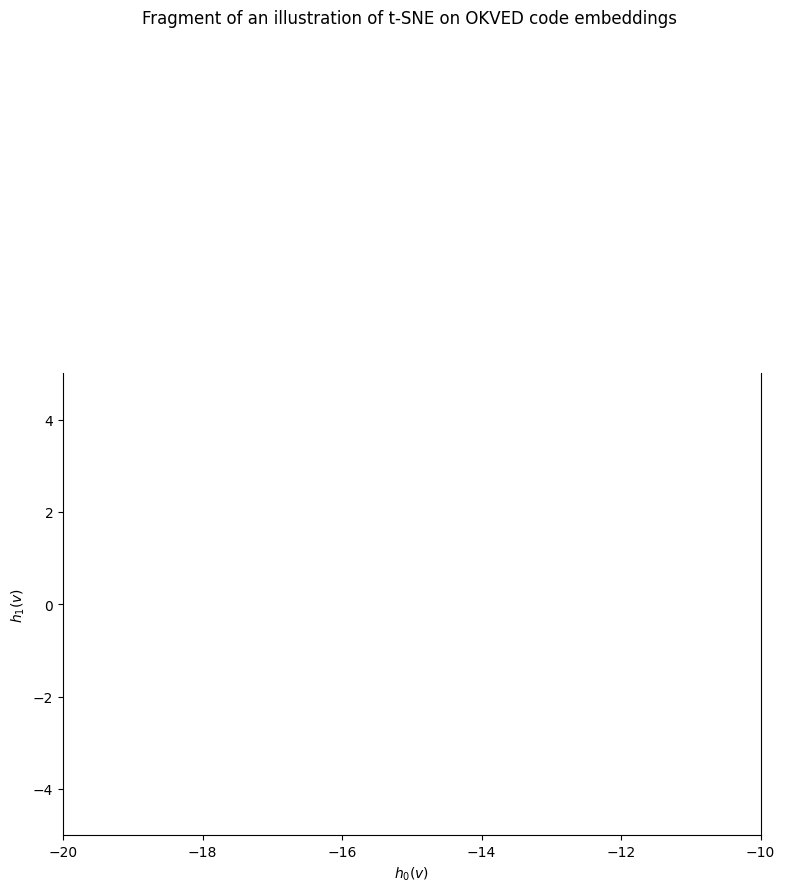

In [63]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# GCN2Conv

In [93]:
class GCN2Conv(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.GCN2Conv(in_feats, layer=1))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.GCN2Conv(in_feats, layer=i+1))
            self.layers.append(gnn.GCN2Conv(in_feats, layer=n_layers))
        else:
            self.layers.append(gnn.GCN2Conv(in_feats, layer=0))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [94]:
best_state = None
num_layers = 2
writer_path = './runs/GCN2Conv_v2'
model_name = 'GCN2Conv_v2'
model = GCN2Conv(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [95]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 733
Best loss = 0.6639739871025085
Best loss = 0.6639739871025085


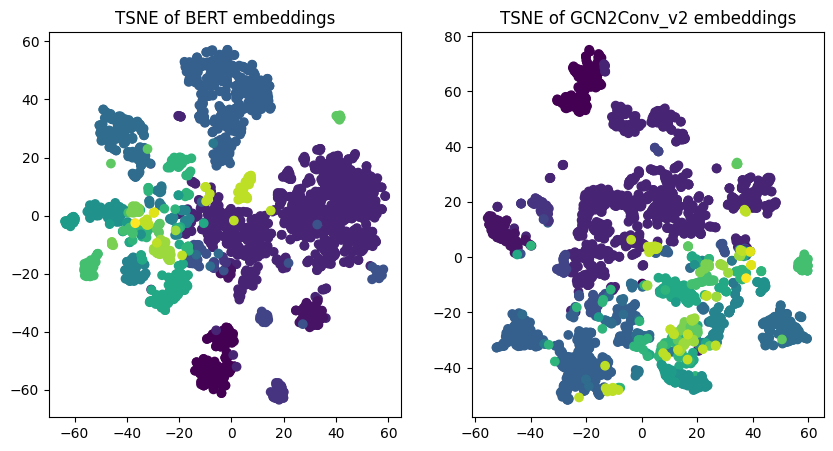

In [96]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [97]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -3.56±7.81
Берт: 0.22±0.42
SVR BERT: -0.08
SVR модель: -1.46
Линейная регрессия BERT: 0.09
Линейная регрессия модель 0.11


In [98]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [99]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:05<00:00, 451.46it/s]


In [100]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

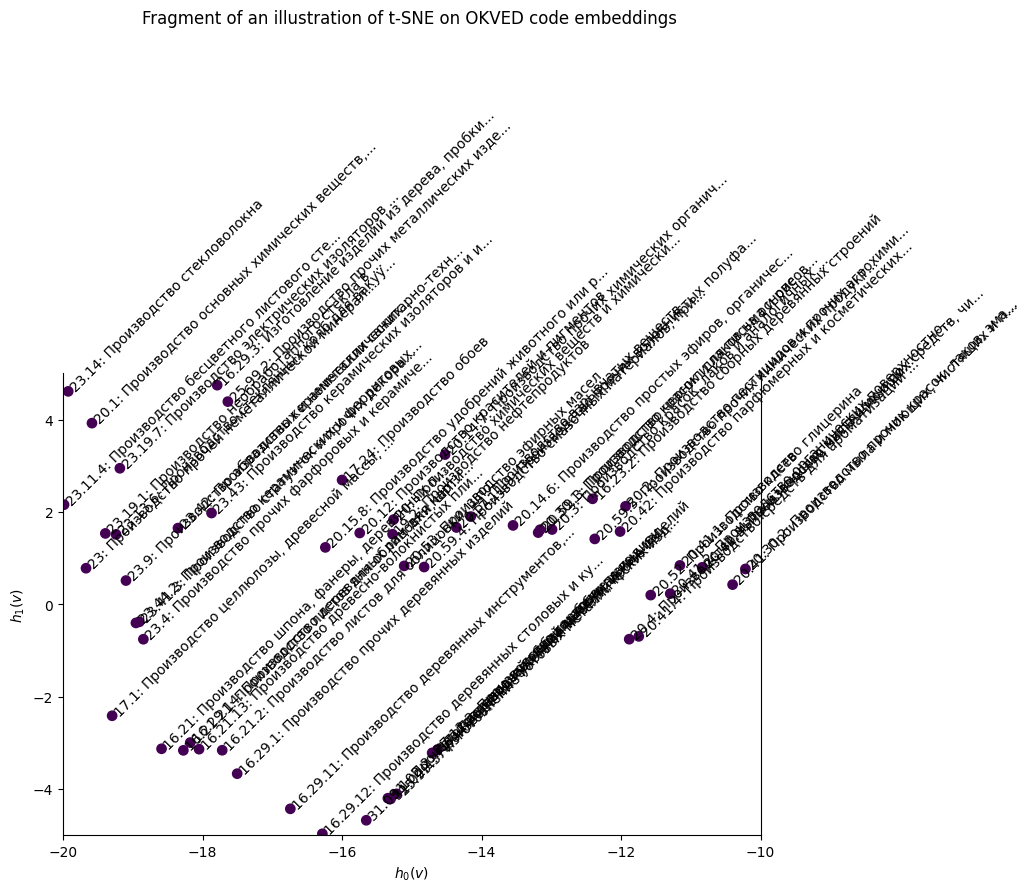

In [101]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))

# GatV2

In [73]:
class GATv2Conv(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        if n_layers > 1:
            self.layers.append(gnn.GATv2Conv(in_feats, n_hidden, num_heads=4))
            for i in range(1, n_layers - 1):
                self.layers.append(gnn.GATv2Conv(n_hidden, n_hidden, num_heads=4))
            self.layers.append(gnn.GATv2Conv(n_hidden, n_classes, num_heads=4))
        else:
            self.layers.append(gnn.GATv2Conv(in_feats, n_classes, num_heads=4))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, x):
        h = x
        for l, layer in enumerate(self.layers):
            h = layer(g, h).mean(dim=1)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [74]:
num_layers = 2
best_state = None
writer_path = './runs/gatv2_v2'
model_name = 'GAT_v2_v2'
model = GATv2Conv(in_feats, num_hidden, num_hidden, num_layers, F.relu, dropout)
model = model.to(device)
sampler = NegativeSampler(g, num_negs, neg_share, device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(writer_path)

In [75]:
train(model=model,
      sampler=sampler,
      graph=g,
      writer=writer,
      num_epochs=num_epochs,
      nfeat=nfeat,
      criterion=criterion,
      optimizer=optimizer,
      require_improvements=require_improvements)

No improvement found during the 50 last iterations, stopping optimization. on epoch = 76
Best loss = 0.6897212266921997
Best loss = 0.6897212266921997


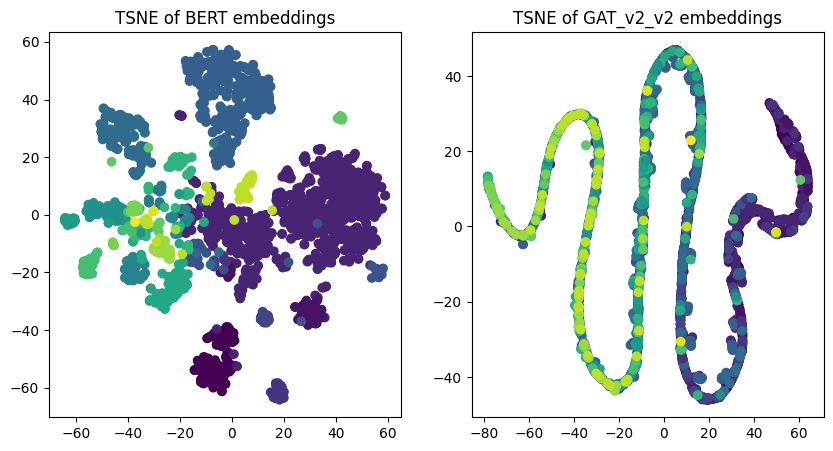

In [78]:
model.eval()
embeddings_model = model(g, nfeat).detach().numpy()[1:2637]
get_embs_and_plot(embeddings_model, g, nfeat, model_name, sections)

In [79]:
bert_scores, linear_regression_score_bert, svm_score_bert, model_scores, linear_regression_score_model, svm_score_model = eval_model(model_name)
joblib.dump(value=bert_scores, filename=f"../results/scores/scores_bert.pickle")
joblib.dump(value=model_scores, filename=f"../results/scores/scores_{model_name}.pickle")
print(f'Модель: {np.mean(model_scores):.2f}±{np.std(model_scores):.2f}')
print(f'Берт: {np.mean(bert_scores):.2f}±{np.std(bert_scores):.2f}')
print(f'SVR BERT: {svm_score_bert:.2f}')
print(f'SVR модель: {svm_score_model:.2f}')
print(f'Линейная регрессия BERT: {linear_regression_score_bert:.2f}')
print(f'Линейная регрессия модель {linear_regression_score_model:.2f}')

Модель: -4.96±10.93
Берт: 0.19±0.48
SVR BERT: -0.08
SVR модель: -2.67
Линейная регрессия BERT: 0.09
Линейная регрессия модель -0.45


In [80]:
embeddings_model = np.load(file=f"../results/embs/{model_name}.npy")
embeddings_model_2d = np.load(file=f"../results/embs/{model_name}_2d.npy")

dim = embeddings_model.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings_model)

In [81]:
topn = 7
with open('results.txt', 'w', encoding='utf8') as fp:
    order = list(range(len(okved_data)))
    shuffle(order)
    for idx in tqdm(order):
        # print(idx)
        D, I = index.search(embeddings_model[[idx]], topn)
        data = okved_data['native_code'] + ' ' + okved_data['name_okved']
        closest = data.iloc[I[0]].tolist()
        closest_s = '\n'.join(closest)
        fp.write(f"{idx}\n{closest_s}\n\n")

100%|██████████| 2636/2636 [00:02<00:00, 1201.03it/s]


In [82]:
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values

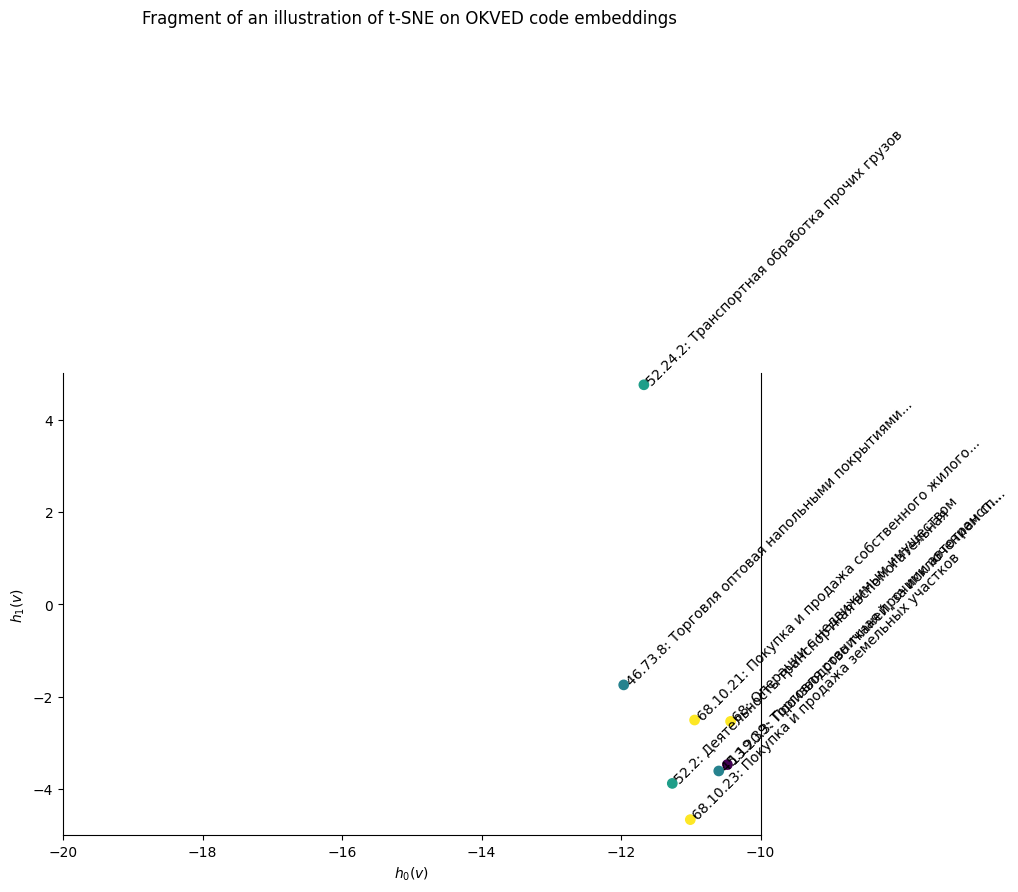

In [83]:
okved_data[okved_data['native_code']=='46.72.21'].index[0]-1
names = (okved_data['native_code'] + ': ' + okved_data['name_okved']).apply(cut, ln=50)
colors = okved_data['section_id'].values
draw_2d(embeddings_model_2d, names, colors, 
        xlim=(-20, -10), ylim=(-5, 5), 
        figsize=(9, 6), annotate=True,
        node_size=45,
        hide_spins=('top', ))